<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Alzheimer's Image Classification

---
## Problem Statement

Fill this in

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.6.0
Found GPU at: /device:GPU:0


In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import MobileNetV3Small, InceptionV3

## Pretrained Neural Network

### Train and Test Data (No Data Augmentation)

In [4]:
# Create Test and Train 
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.33)

# Data Augmentation referenced from "Deep Learning with Python by Francois Chollet: Chapter 5"
train_datagen_aug = ImageDataGenerator(rescale=1.0/255, 
                                   validation_split=0.33,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = '/content/drive/MyDrive/data/train'
test_dir = '/content/drive/MyDrive/data/test'
img_width = 176
img_height = 208


train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42
)

train_gen_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='categorical',
    seed=42
)

Found 3433 images belonging to 4 classes.
Found 3433 images belonging to 4 classes.
Found 1688 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [5]:
train_steps = train_gen.samples // train_gen.batch_size
val_steps = validation_gen.samples // validation_gen.batch_size
print(train_steps)
print(val_steps)

53
26


In [6]:
train_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [7]:
train_gen.image_shape

(208, 176, 3)

Base line accuracy is 50%. Best accuracy of basic fine tuned model is 60%.

### InceptionV3

In [8]:
# Instantantiate base model
conv_base = InceptionV3(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet')
conv_base.trainable = False
conv_base.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 176, 208, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 87, 103, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 87, 103, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 87, 103, 32)  0           batch_normalization[0][0]        
______________________

In [9]:
def create_model():
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy', Precision(), Recall()])
  return model

In [10]:
model = create_model()

In [11]:
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_gen,
      validation_data=validation_gen,
      epochs=60,
      steps_per_epoch=train_steps,
      validation_steps=val_steps
  )

Epoch 1/60
53/53 [==============================] - 1558s 29s/step - loss: 15.6892 - accuracy: 0.4918 - precision: 0.5013 - recall: 0.4530 - val_loss: 1.2575 - val_accuracy: 0.3516 - val_precision: 0.3463 - val_recall: 0.2464
Epoch 2/60
53/53 [==============================] - 12s 236ms/step - loss: 0.9340 - accuracy: 0.5613 - precision: 0.6559 - recall: 0.4102 - val_loss: 1.0761 - val_accuracy: 0.4934 - val_precision: 0.6483 - val_recall: 0.2903
Epoch 3/60
53/53 [==============================] - 12s 234ms/step - loss: 0.8714 - accuracy: 0.5646 - precision: 0.6791 - recall: 0.4265 - val_loss: 1.2470 - val_accuracy: 0.4615 - val_precision: 0.4877 - val_recall: 0.3456
Epoch 4/60
53/53 [==============================] - 13s 238ms/step - loss: 0.8519 - accuracy: 0.5770 - precision: 0.7089 - recall: 0.4417 - val_loss: 1.1349 - val_accuracy: 0.3708 - val_precision: 0.5295 - val_recall: 0.2644
Epoch 5/60
53/53 [==============================] - 12s 232ms/step - loss: 0.8090 - accuracy: 0.610

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision']
val_prec = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

epochs_range = range(60)

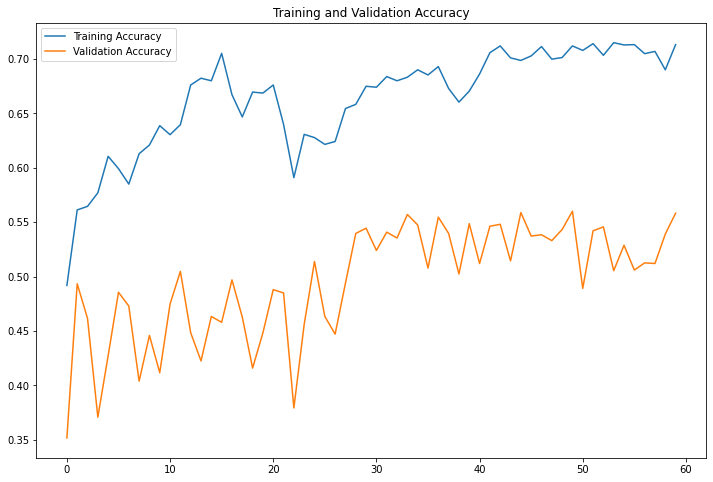

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

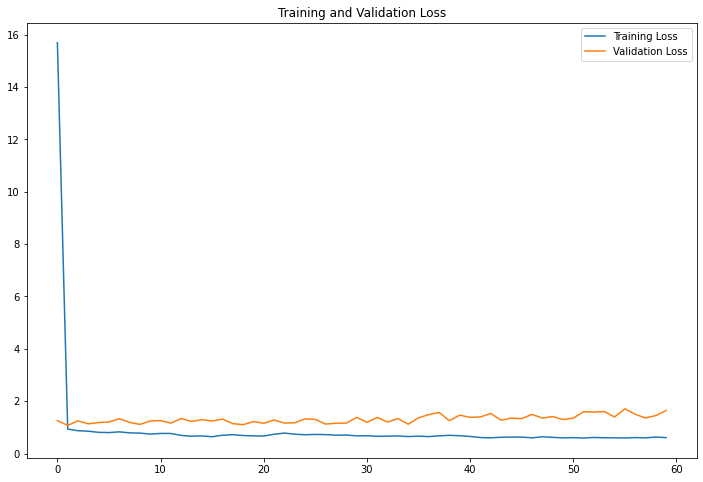

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend();

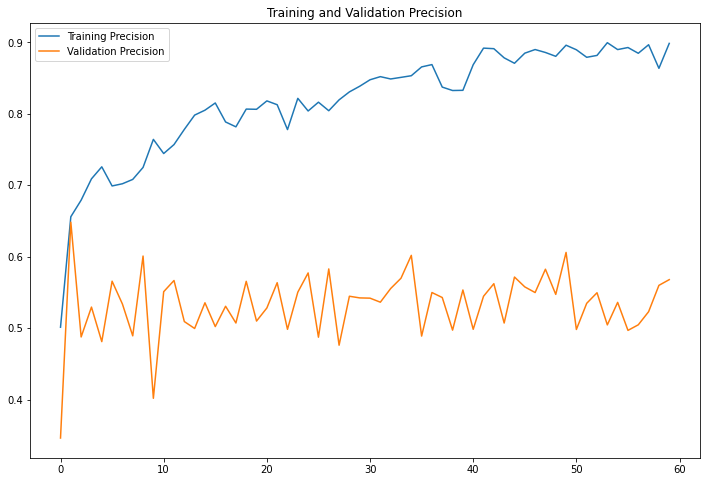

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend();

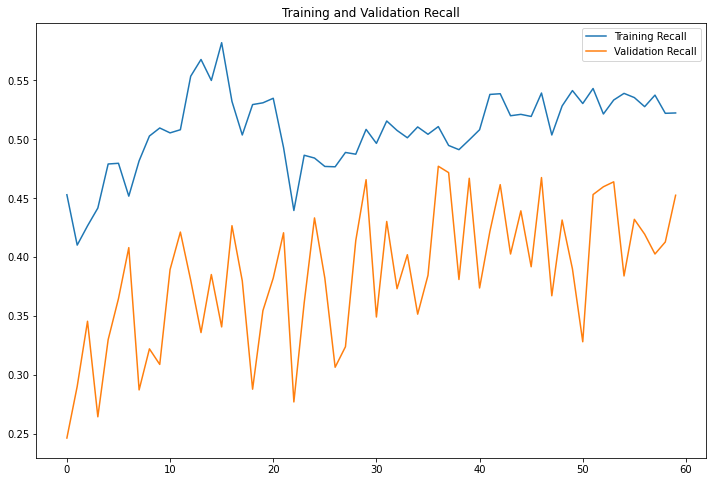

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend();

Based on all the charts, InceptionV3 model is overfit, but less overfit than our fine tuned model without data augmentation. It is performaning better than our initial model. After about 50 epochs the model stops improving. The best accuracy is about 56%, the best precision is about 60% and best recall score is about 40%. This model performs slightly worst than the fine tuned model without data augmentation.

### InceptionV3 with Data Augmentation

In [17]:
model_aug = create_model()
model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 40960)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               10486016  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 32,289,828
Trainable params: 10,487,044
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
with tf.device('/device:GPU:0'):
  history = model_aug.fit(
      train_gen_aug,
      validation_data=validation_gen,
      epochs=60,
      steps_per_epoch=train_steps,
      validation_steps=val_steps
  )

Epoch 1/60
53/53 [==============================] - 44s 742ms/step - loss: 10.2472 - accuracy: 0.4354 - precision_1: 0.4423 - recall_1: 0.3310 - val_loss: 1.1291 - val_accuracy: 0.4087 - val_precision_1: 0.6111 - val_recall_1: 0.0198
Epoch 2/60
53/53 [==============================] - 37s 695ms/step - loss: 1.1108 - accuracy: 0.4737 - precision_1: 0.5569 - recall_1: 0.2455 - val_loss: 1.0909 - val_accuracy: 0.4748 - val_precision_1: 0.7857 - val_recall_1: 0.0727
Epoch 3/60
53/53 [==============================] - 37s 699ms/step - loss: 1.0524 - accuracy: 0.5028 - precision_1: 0.6070 - recall_1: 0.2618 - val_loss: 1.0687 - val_accuracy: 0.4633 - val_precision_1: 0.7679 - val_recall_1: 0.1034
Epoch 4/60
53/53 [==============================] - 37s 701ms/step - loss: 1.0320 - accuracy: 0.5105 - precision_1: 0.6334 - recall_1: 0.2671 - val_loss: 1.0739 - val_accuracy: 0.5120 - val_precision_1: 0.8686 - val_recall_1: 0.1232
Epoch 5/60
53/53 [==============================] - 37s 695ms/step 

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

prec = history.history['precision_1']
val_prec = history.history['val_precision_1']

recall = history.history['recall_1']
val_recall = history.history['val_recall_1']

epochs_range = range(60)

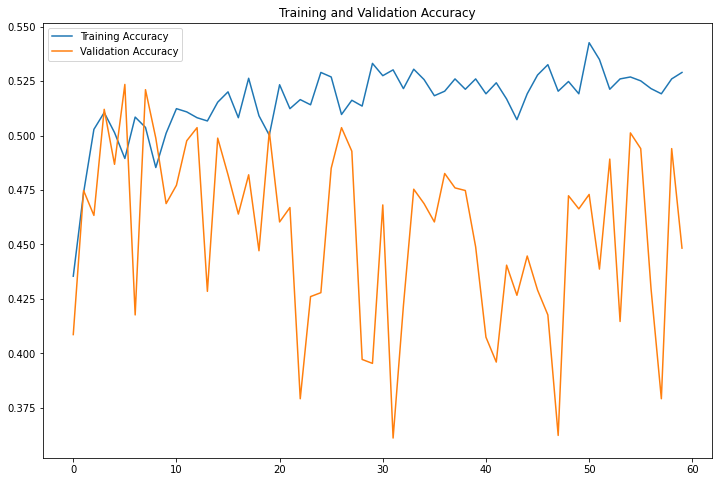

In [20]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

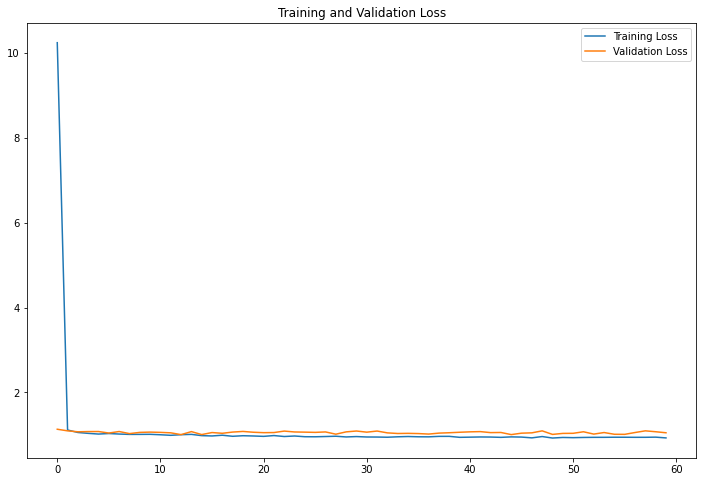

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend();

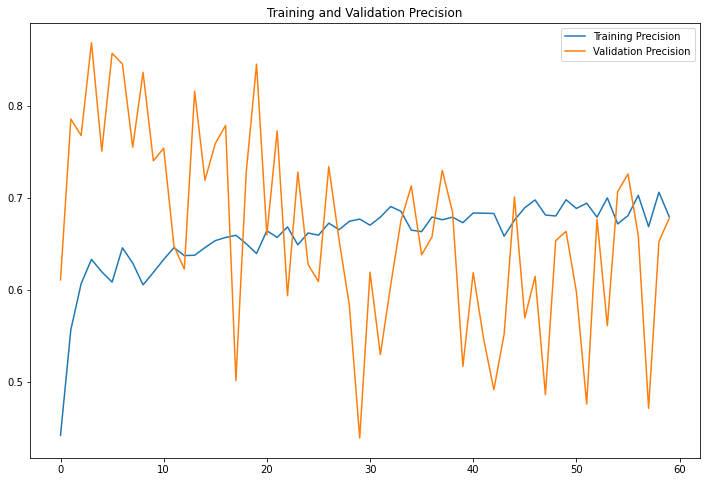

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, prec, label='Training Precision')
plt.plot(epochs_range, val_prec, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend();

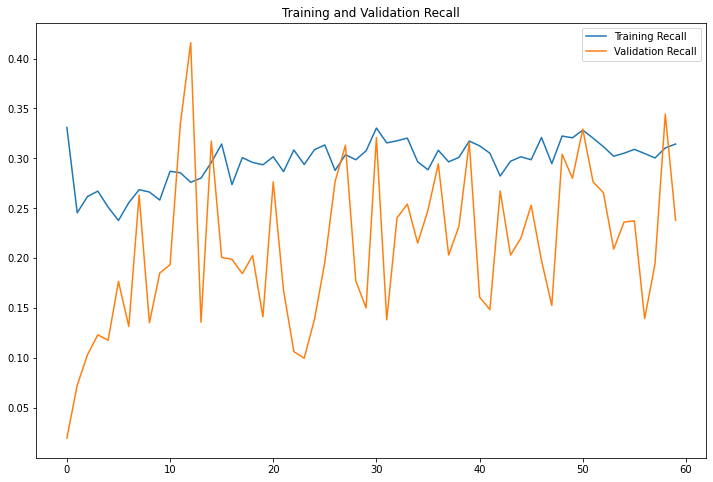

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, recall, label='Training Recall')
plt.plot(epochs_range, val_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend();

Based off the charts, the augmented model stops improving after about 6 epochs. Model is slightly overfit. Best accuracy score is about 52%, best precision is about 86% and best recall is about 18%. Overall model performs worst than unaugmented model and basic fine-tuned model.

In [24]:
# save best inception v3 model
model.save('/content/drive/MyDrive/project-5/inceptionv3-model.h5')